seed = 52772
Standard scaling will not change y, so class balance stays the same before and after standardization.
Train: n=341
class 0: 127 (37.2%)
class 1: 214 (62.8%)
Val: n=114
class 0: 43 (37.7%)
class 1: 71 (62.3%)
Test: n=114
class 0: 42 (36.8%)
class 1: 72 (63.2%)


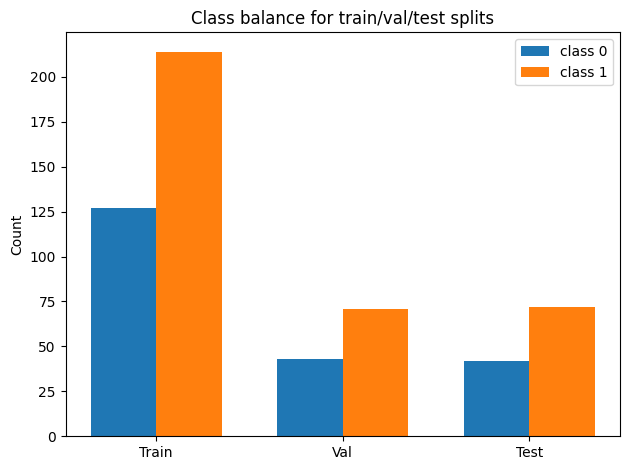

In [9]:
# 2 Task 2: Classification — Probabilistic & Linear Models
# Dataset: Breast Cancer Wisconsin (Diagnostic).
# Goal: Implement GNB, GDA (shared and class-specific covariance), Logistic Regression via
# gradient descent, and Perceptron (or averaged perceptron) from scratch.

# 2.1 2A. Data Preprocessing (Required)
# 1. Use your seed to create a 60/20/20 train/validation/test split.
# 2. Standardize features (justify if you choose otherwise).
# 3. Report class balance and at least one visualization.
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

with open("seed.txt", "r") as f:
    seed = int(f.read().strip())

print(f"seed = {seed}")

#Load dataset
data = load_breast_cancer()
X = data.data.astype(float)          
y = data.target.astype(int)          
feature_names = data.feature_names
target_names = data.target_names  

#60/20/20 split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=seed, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=seed, stratify=y_temp
)

#Standardize using TRAIN statistics only
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0, ddof=0)
sigma[sigma == 0] = 1.0  #prevents division by zero

X_train_std = (X_train - mu) / sigma
X_val_std   = (X_val   - mu) / sigma
X_test_std  = (X_test  - mu) / sigma

#Class balance reporting helper
def report_balance(name, y_split):
    n = len(y_split)
    
    #count how many samples belong to each class; binary classification 0 or 1
    counts = np.bincount(y_split, minlength=2) 

    #convert count to percentage
    percentage = counts / n * 100 

    print(f"{name}: n={n}")
    print(f"class 0: {counts[0]} ({percentage[0]:.1f}%)")
    print(f"class 1: {counts[1]} ({percentage[1]:.1f}%)")


print("Standard scaling will not change y, so class balance stays the same before and after standardization.")
report_balance("Train", y_train)
report_balance("Val", y_val)
report_balance("Test", y_test)

# Visualization
splits = ["Train", "Val", "Test"]
counts0 = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
counts1 = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

x = np.arange(3)
width = 0.35

plt.figure()
plt.bar(x - width/2, counts0, width, label="class 0")
plt.bar(x + width/2, counts1, width, label="class 1")
plt.xticks(x, splits)
plt.ylabel("Count")
plt.title("Class balance for train/val/test splits")
plt.legend()
plt.tight_layout()
plt.show()




In [10]:
# 2.3 2C. Implementations (From Scratch)
# Implement fit and predict for:
# 1. Gaussian Naive Bayes (log-probabilities required)
# 2. GDA with (i) shared covariance, (ii) class-specific covariance
# 3. Logistic Regression using batch gradient descent (with optional L2)

# You may compare to standard APIs for validation only.

In [13]:
# 4. Perceptron (or averaged perceptron)
class Perceptron:
    # lr: learning rate
    # epochs: the number of times the algorithms goes through during learning 
    # w: weights
    # b: bias
    def __init__(self, lr=0.1, fit_intercept=True):
        self.lr =  float(lr)
        self.epochs = int(epochs)
        self.fit_intercept = bool(fit_intercept)

        self.w = None
        self.b = 0.0
        self.n_features = None
        self.convergence_tolerance = 1e-6

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y).reshape(-1)

        #process data: convert labels to {-1, +1} because sometimes it could be {0, +1}
        unique = np.unique(y)
        if set(unique.tolist()) <= {0,1}:
            y_signed = np.where(y == 1, 1.0, -1.0)
        
        n_samples, n_features = X.shape
        #initilization
        self.n_features = n_features
        self.w = np.zeros(n_features)

        for _ in range(self.epochs):
            #save for convergence checking
            w_old = self.w.copy()
            b_old = self.b

            for i in range(n_samples):
                xi = X[i]
                yi = y[i]

                score = xi @ self.w + (self.b if self.fit_intercept else 0.0)
                y_pred = 1 if score >=0 else -1

                # learning - update w and b if misclassify
                if y_pred != yi:
                    self.w += self.lr * (yi - y_pred) * xi
                    self.b += self.lr * (yi - y_pred)
            w_change = np.linalg.norm(self.w - w_old)
            b_change = abs(self.b -b_old) if self.fit_intercept else 0.0

            if w_change < self.convergence_tolerance and b_change <self.convergence_tolerance:
                print(f"Converged!")
                break

        return self
    def predict(self, X):
        X = np.asarray(X, dtype=float)
        scores = X @ self.w + (self.b if self.fit_intercept else 0.0)
        return (scores >=0).astype(int)
            